<a href="https://colab.research.google.com/github/mezaga/ACIML/blob/aciml-06%2F10%2F22/ACIML_seminario_prototype_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ACIML Prototipo**

Gerardo Meza, UNAM





---

DESCARGA DE AUDIOS:
https://drive.google.com/file/d/1KW_QrFYsts3ccMv222hJsOLWHKCPdCb_/view?usp=sharing


In [ ]:
#@title Carga de Librerias
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1P--SbiazyeD_m3Nxhuz331knZ2B-iWZO" -O encoder2_cdmx.zip && rm -rf /tmp/cookies.txt
!unzip /content/encoder2_cdmx.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=169SFhtDzPuoM0d5YzIdRVjx3C-8dSB7o' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=169SFhtDzPuoM0d5YzIdRVjx3C-8dSB7o" -O decoder2_cdmx.zip && rm -rf /tmp/cookies.txt
!unzip /content/decoder2_cdmx.zip

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1egipBGfxnvWiDE4C0wgr2uO2-xfK3t3R' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1egipBGfxnvWiDE4C0wgr2uO2-xfK3t3R" -O vanilla_encoder.zip && rm -rf /tmp/cookies.txt
!unzip /content/vanilla_encoder.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12XmcSvVEsn3Fdg-SoCGxQGZdKQTSHeDU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12XmcSvVEsn3Fdg-SoCGxQGZdKQTSHeDU" -O vanilla_decoder.zip && rm -rf /tmp/cookies.txt
!unzip /content/vanilla_decoder.zip
from scipy.signal import butter, filtfilt
from scipy import signal
import math
from scipy.signal import butter, sosfilt, sosfreqz
from sklearn.preprocessing import StandardScaler
from ipywidgets import HBox, VBox
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from ipywidgets import interact, interactive, fixed, interact_manual
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import IPython
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import random
sr16k = 16000
AUDIO_LOAD = []
etiquetas = []
track_num = []

def normalize_sum(values):
  env_val = np.array([x.value for x in values])
  env_val = env_val/ env_val.min()
  env_val = env_val/env_val.sum()
  return env_val
  
def sinusoid(freq=440.0, dur=1.0, srate=16000, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

def envelope(atk,dcy,susTime,rel, durs, sr):
 env = np.concatenate((np.linspace(0,atk,int(durs[0]*sr//1)), np.linspace(atk,dcy, int(durs[1]*sr//1)), np.linspace(susTime,susTime, int(durs[2]*sr//1)),np.linspace(susTime,0, int(durs[3]*sr//1))),axis = None)
 if env.shape[0] < sr:
   env = np.concatenate((env,np.zeros(sr - env.shape[0])))
 return env

class SynthGen:
  """This class returns a synth"""
  def __init__(self, sr , envelope):
    self.sr = sr
    #self.osc = osc
    self.env = envelope
    
   ######aun hay que arreglar que carge la carga de la señal 
   
  def sinusoid(self, freq = 100, dur=1.0, amp= 1.0, phase = 0.0): 
    t = np.linspace(0,dur,int( self.sr * dur))
    osc = amp * np.sin(2*np.pi* freq * t + phase)
    return osc

  def am(self, c_freq= 100.0, m_freq = 10.0, dur = 1):
    sig = sinusoid(c_freq,dur) * sinusoid(m_freq, dur)
    return sig * self.env

  def fm(self, c_freq = 100, mod_freq = 10, index_mod = 3, dur = 1):
    carrier = sinusoid(c_freq, dur, 1)
    mod = index_mod * sinusoid(mod_freq, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env

  def fm(self, c_freq = 100, mod_freq = 10, index_mod = 3, dur = 1):
    carrier = sinusoid(c_freq, dur, 1)
    mod = index_mod * sinusoid(mod_freq, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env
   
  def additive(self, freq = 100, harms = 3, dur = 1):
     i = 1
     t = np.linspace(0, dur, math.ceil(self.sr * dur))
    ### initialize a new output
     sig = np.zeros(t.size)
     for harm in range(harms):
       if i == 0:
         x = np.multiply(sinusoid(freq * harm, dur),0.5)
         sig = sig + x
         i+=1
       else:
         x = np.multiply(sinusoid(freq * harm, dur), np.random.rand(1)[0])
         sig = sig + x
         i+=1
      
    ### making sure the maximum amplitude does not exeed 1
     if np.max(sig)>abs(np.min(sig)):
        sig = sig / np.max(sig)
     else:
        sig = sig / -np.min(sig)
     return sig * self.env  
  
  def sustractive(self, lowcut= 800, highcut = 1000):
    
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
            sos = butter_bandpass(lowcut, highcut, fs, order=order)
            y = sosfilt(sos, data)
            return y
        
    num_samples = self.sr
    sig = np.random.rand(num_samples) * 2 - 1
    sig = butter_bandpass_filter(sig, lowcut, highcut, num_samples)
    
    return sig

envdict= {'atk': [0,1.], 'dcy': [0,1.], 'susTime': [0,1.], 'rel': [0,1.]}
synthesis_names = ['amp_mod', 'freq_mod','additive', 'sustractive']
am_param = {'carrier_freq': [20,8000],'mod_freq':[20,8000]}
fm_param = {'carrier_freq': [20,8000],'mod_freq':[20,8000],'index_mod':[0,200]}
add_param = {'fundamental': [20,8000],'harms':[0,200]}
sus_param = {'filterband': [20,8000]}

AUDIO_LOAD = []

def random_val(val_1, size = 1):
  val = sorted(val_1)
  if val[0] != val[1]:
    result = np.random.randint(val[0], val[1], size)[0]
  else:
    result = val[0]
  return result
#### general sliders generation
env = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step=0.01, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

env_synths = dict(zip(synthesis_names,[env for x in range(len(synthesis_names))]))

envdur = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step= 0.01, description= key+'dur',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

env_dur_synths = dict(zip(synthesis_names,[envdur for x in range(len(synthesis_names))]))

gen = [widgets.BoundedIntText(value=7, min=0, max=10,step=1,description='AMOUNT:',disabled=False),
       widgets.Text(value='Synth', placeholder='Type something', description='group_id:', disabled=False)
]


settings_synth = dict(zip(synthesis_names,[gen for x in range(len(synthesis_names))]))



### am synthesis sliders

am = [widgets.IntRangeSlider(value=[4000,8000], min= am_param[key][0], max= am_param[key][1], step= 10, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in am_param.keys()]


button = widgets.Button(
    description='Generate',
)

tab1 = HBox(children = [VBox(children= env_synths['amp_mod']),
                        VBox(children= env_dur_synths['amp_mod']),
                        VBox(children= am) ,
                        VBox(children= settings_synth['amp_mod']),
                        VBox(children = [button])])
                        
@button.on_click
def boton_action(b=None):
  for i in range(settings_synth['amp_mod'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['amp_mod'])
    z = envelope(env_synths['amp_mod'][0].value,env_synths['amp_mod'][1].value,env_synths['amp_mod'][2].value, env_synths['amp_mod'][3].value, norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.am(random_val(am[0].value),random_val(am[1].value), 1)
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    AUDIO_LOAD.append({'gid': settings_synth['amp_mod'][1].value,'id': settings_synth['amp_mod'][1].value + '_' + str(i), 'trackname': settings_synth['amp_mod'][1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0})


######FM
fm = [widgets.IntRangeSlider(value=[fm_param[key][0], fm_param[key][1]], min= fm_param[key][0], max= fm_param[key][1], step= 1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in fm_param.keys()]


button2 = widgets.Button(
    description='Generate',
)

tab2 = HBox(children = [VBox(children= env_synths['freq_mod']),
                        VBox(children= env_dur_synths['freq_mod']),
                        VBox(children= fm) ,
                        VBox(children= settings_synth['freq_mod']),
                        VBox(children = [button2])])
                        
@button2.on_click
def boton2_action(b=None):
  for i in range(settings_synth['freq_mod'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['freq_mod'])
    z = envelope(env_synths['freq_mod'][0].value,env_synths['freq_mod'][1].value,env_synths['freq_mod'][2].value, env_synths['freq_mod'][3].value, norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.fm(random_val(fm[0].value),random_val(fm[1].value),random_val(fm[2].value), 1)
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    AUDIO_LOAD.append({'gid': settings_synth['freq_mod'][1].value,'id': settings_synth['freq_mod'][1].value + '_' + str(i), 'trackname': settings_synth['freq_mod'][1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0})

#######ADDITIVE

add = [widgets.IntRangeSlider(value=[add_param[key][0], add_param[key][1]], min= add_param[key][0], max= add_param[key][1], step= 1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in add_param.keys()]


button3 = widgets.Button(
    description='Generate',
)

tab3 = HBox(children = [VBox(children= env_synths['additive']),
                        VBox(children= env_dur_synths['additive']),
                        VBox(children= add) ,
                        VBox(children= settings_synth['additive']),
                        VBox(children = [button3])])
                        
@button3.on_click
def boton3_action(b=None):
  for i in range(settings_synth['additive'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['additive'])
    z = envelope(env_synths['additive'][0].value,env_synths['additive'][1].value,env_synths['additive'][2].value, env_synths['additive'][3].value, norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.additive(random_val(add[0].value), random_val(add[1].value))
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    AUDIO_LOAD.append({'gid': settings_synth['additive'][1].value,'id': settings_synth['additive'][1].value + '_' + str(i), 'trackname': settings_synth['additive'][1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0})



#######sustractive


sus = [widgets.IntRangeSlider(value=[sus_param[key][0], sus_param[key][1]], min= sus_param[key][0], max= sus_param[key][1], step= 1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in sus_param.keys()]


button4 = widgets.Button(
    description='Generate',
)

tab4 = HBox(children = [VBox(children= env_synths['sustractive']),
                        VBox(children= env_dur_synths['sustractive']),
                        VBox(children= sus) ,
                        VBox(children= settings_synth['sustractive']),
                        VBox(children = [button4])])
                        
@button4.on_click
def boton4_action(b=None):
  for i in range(settings_synth['sustractive'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['sustractive'])
    z = envelope(env_synths['sustractive'][0].value,env_synths['sustractive'][1].value,env_synths['sustractive'][2].value, env_synths['sustractive'][3].value, norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    band = sorted([random_val(sus[0].value) for x in range(2)])
    data = synth.sustractive(band[0], band[1])
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    AUDIO_LOAD.append({'gid': settings_synth['sustractive'][1].value,'id': settings_synth['sustractive'][1].value + '_' + str(i), 'trackname': settings_synth['sustractive'][1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0})


#####
tab = widgets.Tab()
tab.children = [tab1, tab2, tab3, tab4]
tab.set_title(0," amplitude mod")
tab.set_title(1,"fm")
tab.set_title(2,"additive")
tab.set_title(3,"sustractive")


#tab


# En la siguente celda puedes subir, cargar y grabar tus archivos.


In [2]:
#@title Carga de audios { run: "auto" }
## 

from google.colab import files

dropdown = 'crear' #@param ["Subir archivos", "crear", "grabar"]
if dropdown == 'Subir archivos':
  text = [widgets.Text(value='Synth', placeholder='Type something', description='group_id:', disabled=False)
]

  load = HBox(children= text)
  display(load)
  sr16k = 16000
  secs = 1
  uploaded = files.upload()
#track_num.append(len(uploaded))
  for idx, track in enumerate(uploaded.keys()):
    print(track)
    if track.endswith("wav"):
        SR = librosa.get_samplerate(track)
        y, fs = librosa.load(track, SR)
        data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
        ##features (tenemos que arreglar el fft apara que sean valores de amp)
        fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
        f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
      #takes only 1 sec and resample to 16k 
        etiquetas.append(text[0].value)
        AUDIO_LOAD.append({'gid': text[0].value,'id': text[0].value + str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
  
if dropdown ==  'crear': 
  #print('efkwjefwkf')
  display(tab)

if dropdown == 'grabar':
  pass

In [ ]:
#@title Carga de audios
## 

from google.colab import files
#@ tectInserta
text = 'am' #@param {type:"string"}
#AUDIO_LOAD = []
sr16k = 16000
secs = 1
uploaded = files.upload()
#track_num.append(len(uploaded))
for idx, track in enumerate(uploaded.keys()):
  print(track)
  if track.endswith("wav"):
      SR = librosa.get_samplerate(track)
      y, fs = librosa.load(track, SR)
      data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
      ##features (tenemos que arreglar el fft apara que sean valores de amp)
      fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
      f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #takes only 1 sec and resample to 16k 
      etiquetas.append(text)
      AUDIO_LOAD.append({'gid': text,'id': text+ str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
      

Saving am_048.wav to am_048.wav
Saving am_049.wav to am_049.wav
Saving am_050.wav to am_050.wav
Saving am_051.wav to am_051.wav
Saving am_052.wav to am_052.wav
am_048.wav
am_049.wav
am_050.wav
am_051.wav
am_052.wav


# En la siguiente celda podrás visualizar una tabla con múltiples características que los describen la base de datos.

---



In [3]:
#@title DATASET

DATA = pd.DataFrame(AUDIO_LOAD)
#PCA 
data_fft = np.vstack(DATA['fft'])
mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)+ 0.000001
Xmu_FFT = data_fft- mu_fft/s_fft
DATA

,gid,id,trackname,data,fft,f0
0,am,am_0,am_0.wav,"[0.0, 3.323249452910041e-07, 2.650828509345765...","[-1.2304892907218967, -0.26287443958808204, -0...",76.403538
1,am,am_1,am_1.wav,"[0.0, 1.294867355534146e-06, 1.007656490018806...","[-5.916300009154476, -5.8435907026429135, -5.8...",122.818640
2,am,am_2,am_2.wav,"[0.0, 1.4329930562240236e-06, 1.10960639982737...","[-8.930843053479563, -8.978813313875945, -9.04...",99.233401
3,am,am_3,am_3.wav,"[0.0, 8.903594278248278e-07, 6.916919045887244...","[-15.410261192761197, -15.410261192761197, -15...",616.024482
4,am,am_4,am_4.wav,"[0.0, 8.002437791726104e-07, 6.261683148429225...","[-15.403856219459641, -15.403856219459641, -15...",536.447125
5,am,am_5,am_5.wav,"[0.0, 7.206746710692525e-07, 5.698882564671698...","[-15.397266439143294, -15.397266439143294, -15...",85.526490
6,am,am_6,am_6.wav,"[0.0, 1.0665867259854111e-06, 8.30594252567274...","[-15.403084876055772, -15.403084876055772, -15...",575.531072
7,am,am_7,am_7.wav,"[0.0, 1.041962953424869e-06, 8.134586818298324...","[-15.4035408268863, -15.4035408268863, -15.403...",235.195038
8,am,am_8,am_8.wav,"[0.0, 4.899189272637654e-07, 3.900070724275361...","[-15.39725012385719, -15.39725012385719, -15.3...",93.764036
9,am,am_9,am_9.wav,"[0.0, 7.323330695417372e-08, 5.857144386749792...","[14.950500394009298, 13.31643270402839, 24.551...",83.262426


In [4]:
#@title Filtrado
zliders = dict(DATA['gid'].value_counts())
color = list(np.random.choice(np.random.randint(0,30),len(zliders),replace = False))
sliders = []
for key in zliders.keys():
  sliders.append(widgets.IntSlider(value = zliders[key], max= zliders[key], step = 1, description= key))

update_sliders = dict(zip([x for x in zliders], sliders))

ui = widgets.VBox(sliders)

def datafilter(**kwargs):
  '''update n number of sliders corresponding to dataclases by splitting dataset uin subgroups and joining them again'''
  dframes = []
  for key, value in kwargs.items():
    dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value])
    #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
  print(DATA_filt['gid'])
  return DATA_filt


out = widgets.interactive_output(datafilter, update_sliders)
updated_df = datafilter
display(ui,out)

Output()

In [5]:
#@title DATASET
dframes = []
for key, value in update_sliders.items():
  dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value.value])
  #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
audiotracks = dict(zip(DATA_filt['id'],DATA_filt['id'].index))
DATA_filt

,level_0,index,gid,id,trackname,data,fft,f0
0,0,0,am,am_0,am_0.wav,"[0.0, 3.323249452910041e-07, 2.650828509345765...","[-1.2304892907218967, -0.26287443958808204, -0...",76.403538
1,1,1,am,am_1,am_1.wav,"[0.0, 1.294867355534146e-06, 1.007656490018806...","[-5.916300009154476, -5.8435907026429135, -5.8...",122.818640
2,2,2,am,am_2,am_2.wav,"[0.0, 1.4329930562240236e-06, 1.10960639982737...","[-8.930843053479563, -8.978813313875945, -9.04...",99.233401
3,3,3,am,am_3,am_3.wav,"[0.0, 8.903594278248278e-07, 6.916919045887244...","[-15.410261192761197, -15.410261192761197, -15...",616.024482
4,4,4,am,am_4,am_4.wav,"[0.0, 8.002437791726104e-07, 6.261683148429225...","[-15.403856219459641, -15.403856219459641, -15...",536.447125
5,5,5,am,am_5,am_5.wav,"[0.0, 7.206746710692525e-07, 5.698882564671698...","[-15.397266439143294, -15.397266439143294, -15...",85.526490
6,6,6,am,am_6,am_6.wav,"[0.0, 1.0665867259854111e-06, 8.30594252567274...","[-15.403084876055772, -15.403084876055772, -15...",575.531072
7,7,7,am,am_7,am_7.wav,"[0.0, 1.041962953424869e-06, 8.134586818298324...","[-15.4035408268863, -15.4035408268863, -15.403...",235.195038
8,8,8,am,am_8,am_8.wav,"[0.0, 4.899189272637654e-07, 3.900070724275361...","[-15.39725012385719, -15.39725012385719, -15.3...",93.764036
9,9,9,am,am_9,am_9.wav,"[0.0, 7.323330695417372e-08, 5.857144386749792...","[14.950500394009298, 13.31643270402839, 24.551...",83.262426


variance: 
[0.44971858 0.14790508]


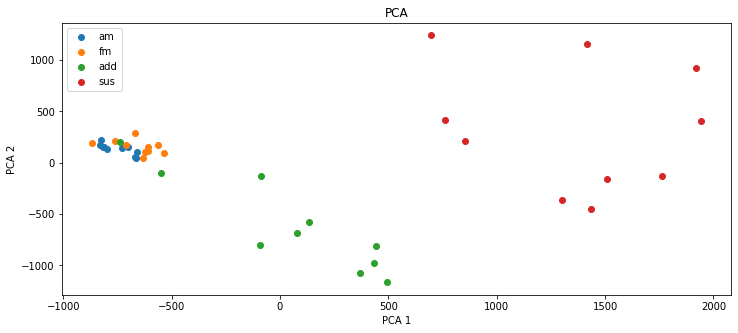

In [27]:
#@title Visualización de datos { run: "auto" }
ids = list(DATA_filt['id'])
audio_viz = 'PCA' #@param ['PCA','F0', 'histogram','spectrogram']
#fig, ax = plt.subplots()
plt.figure(figsize = [12,5])
#fig.set_size_inches([12,5])

if audio_viz == 'histogram':
  ax = plt.subplot(1,1,1)
  ax = DATA_filt['gid'].hist()
  ax.set_xlabel("Synth type")
  ax.set_ylabel(" # of observations")
  plt.show()
if audio_viz == 'F0':
  ax = plt.subplot(1,1,1)
  ax.set_xlabel("Audios")
  ax.set_ylabel(" F0")
  ax.plot(DATA_filt.index, DATA_filt['f0'], linestyle = '--')
  #plt.show()
if audio_viz == 'PCA':
  ax = plt.subplot(1,1,1)
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(Xmu_FFT)
  print('variance: ')
  print(pca.explained_variance_ratio_)
  counter = 0 
  cu = 0

  for key, value in zliders.items():
    #print(key,value)
    ax.scatter(X_PCA[counter: counter + value, 0], X_PCA[counter: counter + value, 1], cmap= 10, label = key)
    counter += value
    cu += 1
  ax.set_title('PCA')
  ax.set_xlabel('PCA 1')
  ax.set_ylabel('PCA 2')
  ax.legend()

if audio_viz == 'spectrogram':
  z = DATA_filt['fft'].sample(3)
  for i, x in enumerate(z):
    ax = plt.subplot(1, 3, i + 1)
    stft = librosa.stft(x)#, n_fft=512, hop_length= (512-1)//2)
    stft = librosa.amplitude_to_db(np.abs(stft),ref=np.max)
    librosa.display.specshow(stft,sr = 16000, y_axis='fft_note', x_axis='time')
    ax.set_title('spectrogram_'+ str(i))
    #ax.set_set_xlabel('time')
  #for idx, id in enumerate(ids):
  #  ax.annotate(id,(X_PCA[idx][0], X_PCA[idx][1]+ 0.2))
  #fig.add_axes(ax)
  
  plt.show()
  


In [9]:
#@title Entrenamiento del modelo

from google.colab import files
##standarizacion de datos
data = np.vstack(DATA_filt['data'])
mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]
Xw = (data- mu_wave)/max_wave
Xw = Xw[...,np.newaxis][...,np.newaxis]

referencia_1 = 'Preentrenado' #@param ['Nuevo modelo','Preentrenado','mi modelo']
Epocas = 39 #@param {type:"slider", min:10, max:10000, step:1}
batches = 5 #@param {type: "integer"}
lr = 0.00008 #@param {type: "slider", min:0.00001, max: 0.0001, step:0.00001}

warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(lr, clipvalue=0.5)
if referencia_1 == 'Preentrenado': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/encoder2_cdmx',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/decoder2_cdmx',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])

if referencia_1 == 'Nuevo modelo': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/vanilla_encoder',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/vanilla_decoder',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs= encoder_inputs, outputs= outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])
else:
  print('.....')
  '''
  new_model = tf.keras.models.load_model('/content/model_vae')
  new_model.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = new_model.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  '''


Epoch 1/39
8/8 [==============================] - 17s 2s/step - loss: 0.1780
Epoch 2/39
8/8 [==============================] - 15s 2s/step - loss: 0.1539
Epoch 3/39
8/8 [==============================] - 16s 2s/step - loss: 0.1506
Epoch 4/39
8/8 [==============================] - 15s 2s/step - loss: 0.1472
Epoch 5/39
8/8 [==============================] - 15s 2s/step - loss: 0.1438
Epoch 6/39
8/8 [==============================] - 17s 2s/step - loss: 0.1411
Epoch 7/39
8/8 [==============================] - 15s 2s/step - loss: 0.1373
Epoch 8/39
8/8 [==============================] - 15s 2s/step - loss: 0.1339
Epoch 9/39
8/8 [==============================] - 17s 2s/step - loss: 0.1301
Epoch 10/39
8/8 [==============================] - 20s 3s/step - loss: 0.1273
Epoch 11/39
8/8 [==============================] - 15s 2s/step - loss: 0.1249
Epoch 12/39
8/8 [==============================] - 20s 3s/step - loss: 0.1222
Epoch 13/39
8/8 [==============================] - 16s 2s/step - loss: 0.

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


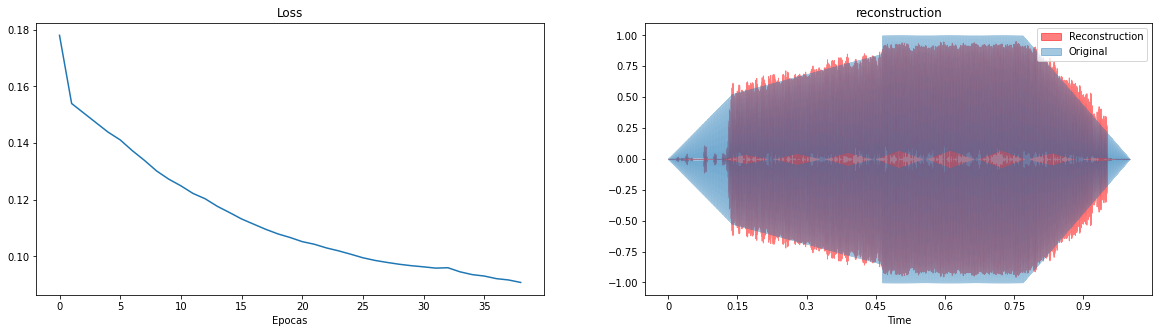

In [10]:
#@title Evaluación del modelo
#una visualización donde se vea la curva del modelo junto a la recunstruccion

def latent_vectorize(audio_id,df,audio_list):
  audio_idx = list(df[df['id'] == audio_id].index)[0]
  latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
  return latent_gen[0]

def latent_reconstruction(latent_gen):
  recons = decoder_pretrained.predict(latent_gen[0:])
  recons= recons[0].flatten()
  return recons


def latent_search(audio_id, df, audio_list):
  '''function that retrieves the correct audio representation in the latent space'''
  try:
    latent_gen = latent_vectorize(audio_id,df,audio_list)
    recons = latent_reconstruction(latent_gen)
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
    
def latent_inter(audio_a, audio_b, step = 100, porcentaje = 50, audio_list = Xw):
  'crea 100 vectores pensados en % y reconstruye'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  else:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  return res

'''
def latent_search(audio_id, df, audio_list):
 ''''''function that retrieves the correct audio representation in the latent space''''''
  try:
    audio_idx = list(df[df['id'] == audio_id].index)[0]
    latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
    recons = decoder_pretrained.predict(latent_gen[0][0:])
    recons= recons[0].flatten()
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
'''

def gps_latent(dic_tracks, df, data):
  '''search all track ids position in the latent space in an ''orderly fashion'' '''
  res_latent = []
  for key in dic_tracks.keys():
    res_latent.append(latent_search(key, df, data)[0])
  return res_latent

all_tracks_latent = gps_latent(audiotracks, DATA_filt, Xw)



track = random.choices(ids)[0]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(5)
ax[0].plot(tr_logs.history['loss'])
librosa.display.waveshow(latent_search(track, DATA_filt, Xw)[1], sr=16000, color='r', alpha=0.5, ax=ax[1], label='Reconstruction')
librosa.display.waveshow(Xw[audiotracks[track]].flatten(), sr=16000, alpha=0.4, ax=ax[1], label='Original')
ax[1].legend()
ax[0].set_xlabel("Epocas")
ax[0].set_title('Loss')
ax[1].set_title('reconstruction')


####archivos de audio
IPython.display.display(IPython.display.Audio(Xw[audiotracks[track]].flatten(), rate = sr16k))
IPython.display.display(IPython.display.Audio(latent_search(track, DATA_filt, Xw)[1],rate = sr16k))

In [34]:
#@title DATOS
from IPython.display import display
import ipywidgets as widgets

import matplotlib.pyplot as plt

def setup_ui(df):
    
    out = widgets.Output()
    with out:
        display(df)
    return out
 
def viz_ui():
    out = widgets.Output()
    with out:
      z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
      s = sinusoid(100)
      plt.plot(s * z)
      plt.ylabel('some numbers')
      display(plt.show())
    return out  



df_display = HBox(children = [setup_ui(DATA_filt)])
latent_display = HBox(children = [viz_ui()])

tab = widgets.Tab()
tab.children = [latent_display, df_display,]
tab.set_title(0,"latent space")
tab.set_title(1,"visualization")
tab

1/1 [==============================] - 1s 596ms/step


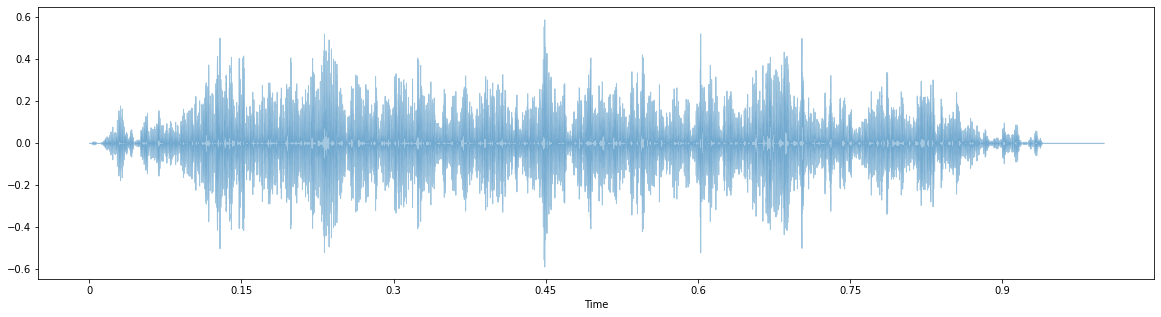

In [19]:
#@title Exploración y generación { run: "auto" }
audio_id = 'am_1' #@param {type:"string"}
audio_id2 = 'fm_0' #@param {type:"string"}

porcentaje_de_cambio = 5 #@param {type:"slider", min:1, max:10, step:1}
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)

idx = list(DATA_filt[DATA_filt['id'] == audio_id].index)[0]
idx2 = list(DATA_filt[DATA_filt['id'] == audio_id2].index)[0]
audio_a = all_tracks_latent[0][idx]
audio_b = all_tracks_latent[0][idx2]
inter = latent_inter(audio_a, audio_b, 10, porcentaje_de_cambio)

#a_1 = latent_search(audio)[0]
#a_2 = latent_search(audio)[0]

#inter = latent_inter(a_1,a_2, 100, porcentaje_de_cambio)
#ax.plot(inter)
librosa.display.waveshow(inter, sr=16000, alpha=0.4, label='Original')
IPython.display.display(IPython.display.Audio(inter, rate = sr16k))



******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

In [ ]:
#@title Descarga de materiales
!zip -r /content/model_vae.zip /content/model_vae

modelo = True #@param {type:"boolean"}
espacio_latente = True #@param {type:"boolean"}
boolean_checkbox = True #@param {type:"boolean"}

if modelo == True:
  files.download('/content/model_vae.zip')

'am_4.wav'

In [ ]:
from scipy.io import wavfile
SR = 44100
def get_val(osc, sample_rate=SR):
    return [next(osc) for i in range(sample_rate)]

def plot_osc(Osc, name=""):
    fig = plt.figure(figsize=figsize)

    f = 8
    plt.title(f"{f}Hz {name} Wave")
    for a,p,c in zip([1.0,0.9,0.8,0.7],[0,15,30,45],colors):
        osc = Osc(freq=f,amp=a,phase=p); iter(osc)
        plt.plot(get_val(osc), color=c, label=f"amp:{a}, phase:{p:02}°")

    plt.legend(loc='lower right')
    fig.savefig(f"{name.lower()}_all.jpg")

def get_seq(osc, dur):
    samples = []
    osc = iter(osc)
    for _ in range(int(SR * dur)):
      samples.append(next(osc))
    return samples

to_16 = lambda wav, amp: np.int16(wav * amp * (2**15 - 1))

def wave_to_file(wav, wav2=None, fname="temp.wav", amp=0.1):
    wav = np.array(wav)
    wav = to_16(wav, amp)
    if wav2 is not None:
        wav2 = np.array(wav2)
        wav2 = to_16(wav2, amp)
        wav = np.stack([wav, wav2]).T
    
    wavfile.write(fname, SR, wav)

In [ ]:
def envelope(atk,dcy,susTime,rel, durs, sr):
 env = np.concatenate((np.linspace(0,atk,int(durs[0]*sr/1)), np.linspace(atk,dcy, int(durs[1]*sr/1)), np.linspace(susTime,susTime, int(durs[2]*sr/1)),np.linspace(susTime,0, int(durs[3]*sr/1))),axis = None)
 return env

In [ ]:
def sinusoid(freq=440.0, dur=1.0, srate=16000, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

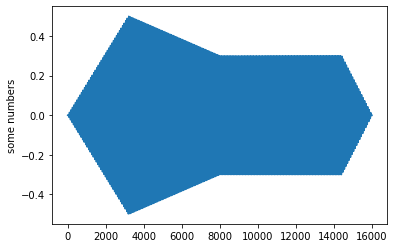

In [ ]:

z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
s = sinusoid(100)
s = am([100,1],2)
s = addsyn(200,1,[0.5,0.2,0.1])
#s = fm([100,23],1,10)
signal = s * z
import matplotlib.pyplot as plt
plt.plot(s*z)
plt.ylabel('some numbers')
plt.show()

In [ ]:
def fm(freqs,dur,k):
  carrier = sinusoid(freqs[0],1,16000*dur,1)
  mod = k * sinusoid(freqs[1],1,16000*dur)
  sig = np.cos(carrier + mod)
  return sig

In [ ]:
sig = am([440,10],1,16000,[1,0.4],0)

In [ ]:
sig = fm([440,10],1,16000,[1,20],0)

In [ ]:
z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000)


(16000,)

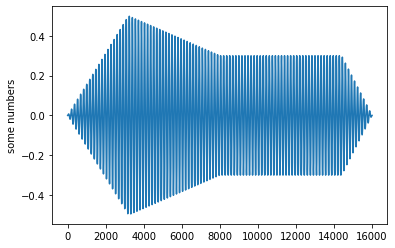

In [ ]:

z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
s = sinusoid(100)
#s = am([100,1],2)
#s = addsyn(200,1,[0.5,0.2,0.1,0.1,0.1])

#s = fm([100,23],1,10)
signal = samples * z
import matplotlib.pyplot as plt
plt.plot(s*z)
plt.ylabel('some numbers')
plt.show()


In [155]:
from scipy.signal import butter, filtfilt
from scipy import signal
import math
from scipy.signal import butter, sosfilt, sosfreqz
import numpy as np

def sinusoid(freq=440.0, dur=1.0, srate=16000, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

def envelope(atk,dcy,susTime,rel, durs, sr):
 env = np.concatenate((np.linspace(0,atk,int(durs[0]*sr//1)), np.linspace(atk,dcy, int(durs[1]*sr//1)), np.linspace(susTime,susTime, int(durs[2]*sr//1)),np.linspace(susTime,0, int(durs[3]*sr//1))),axis = None)
 if env.shape[0] < sr:
   env = np.concatenate((env,np.zeros(sr - env.shape[0])))
 return env

class SynthGen:
  """This class returns a synth"""
  def __init__(self, sr , envelope):
    self.sr = sr
    #self.osc = osc
    self.env = envelope
    
   ######aun hay que arreglar que carge la carga de la señal 
   
  def sinusoid(self, freq = 100, dur=1.0, amp= 1.0, phase = 0.0): 
    t = np.linspace(0,dur,int( self.sr * dur))
    osc = amp * np.sin(2*np.pi* freq * t + phase)
    return osc

  def am(self, c_freq= 100.0, m_freq = 10.0, dur = 1):
    sig = sinusoid(c_freq,dur) * sinusoid(m_freq, dur)
    return sig * self.env

  def fm(self, c_freq = 100, mod_freq = 10, index_mod = 3, dur = 1):
    carrier = sinusoid(c_freq, dur, 1)
    mod = index_mod * sinusoid(mod_freq, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env

  def fm(self, c_freq = 100, mod_freq = 10, index_mod = 3, dur = 1):
    carrier = sinusoid(c_freq, dur, 1)
    mod = index_mod * sinusoid(mod_freq, dur)
    sig = np.cos(carrier + mod)
    return sig * self.env
  
  def additive(self, freq = 100, harms = 3, dur = 1):
     i = 1
     t = np.linspace(0, dur, math.ceil(self.sr * dur))
    ### initialize a new output
     sig = np.zeros(t.size)
     for harm in range(harms):
       if i == 0:
         x = np.multiply(sinusoid(freq * harm, dur),0.5)
         sig = sig + x
         i+=1
       else:
         x = np.multiply(sinusoid(freq * harm, dur), np.random.rand(1)[0])
         sig = sig + x
         i+=1
      
    ### making sure the maximum amplitude does not exeed 1
     if np.max(sig)>abs(np.min(sig)):
        sig = sig / np.max(sig)
     else:
        sig = sig / -np.min(sig)
     return sig * self.env
  

  def sustractive(self, lowcut= 800, highcut = 1000):
    
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
            sos = butter_bandpass(lowcut, highcut, fs, order=order)
            y = sosfilt(sos, data)
            return y
        
    num_samples = self.sr
    sig = np.random.rand(num_samples) * 2 - 1
    sig = butter_bandpass_filter(sig, lowcut, highcut, num_samples)
    
    return sig * self.env

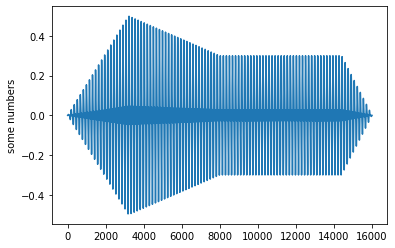

In [156]:
import matplotlib.pyplot as plt

sr = 16000
z = envelope(0.5,0.3,0.3,0.1,[0.2,0.3,0.4,0.1], 16000*1)
synth = SynthGen(sr, z)
s = synth.additive()


#z = synth.sustractive()

plt.plot(s)
plt.ylabel('some numbers')
plt.show()

In [ ]:
import IPython
IPython.display.display(IPython.display.Audio(AM[1], rate = 16000))


In [159]:
from ipywidgets import HBox, VBox
import ipywidgets as widgets
import librosa
from ipywidgets import TwoByTwoLayout
sr16k = 16000
etiquetas = []
AUDIO_LOAD = []

envdict= {'atk': [0,1.], 'dcy': [0,1.], 'susTime': [0,1.], 'rel': [0,1.]}
synthesis_names = ['amp_mod', 'freq_mod','additive', 'sustractive']
am_param = {'carrier_freq': [20,8000],'mod_freq':[20,8000]}
fm_param = {'carrier_freq': [20,8000],'mod_freq':[20,8000],'index_mod':[0,200]}
add_param = {'fundamental': [20,8000],'harms':[0,200]}
sus_param = {'filterband': [20,8000]}

AUDIO_LOAD = []

def random_val(val_1, size = 1):
  val = sorted(val_1)
  if val[0] != val[1]:
    result = np.random.randint(val[0], val[1], size)[0]
  else:
    result = val[0]
  return result
#### general sliders generation
env = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step=0.01, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

env_synths = dict(zip(synthesis_names,[env for x in range(len(synthesis_names))]))

envdur = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step= 0.01, description= key+'dur',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

env_dur_synths = dict(zip(synthesis_names,[envdur for x in range(len(synthesis_names))]))

gen = [widgets.BoundedIntText(value=7, min=0, max=10,step=1,description='AMOUNT:',disabled=False),
       widgets.Text(value='Synth', placeholder='Type something', description='group_id:', disabled=False)
]


settings_synth = dict(zip(synthesis_names,[gen for x in range(len(synthesis_names))]))



### am synthesis sliders

am = [widgets.IntRangeSlider(value=[4000,8000], min= am_param[key][0], max= am_param[key][1], step= 10, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in am_param.keys()]


button = widgets.Button(
    description='Generate',
)

tab1 = HBox(children = [VBox(children= env_synths['amp_mod']),
                        VBox(children= env_dur_synths['amp_mod']),
                        VBox(children= am) ,
                        VBox(children= settings_synth['amp_mod']),
                        VBox(children = [button])])
                        
@button.on_click
def boton_action(b=None):
  for i in range(settings_synth['amp_mod'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['amp_mod'])
    z = envelope(env_synths['amp_mod'][0].value,env_synths['amp_mod'][1].value,env_synths['amp_mod'][2].value, env_synths['amp_mod'][3].value, norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.am(random_val(am[0].value),random_val(am[1].value), 1)
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    AUDIO_LOAD.append({'gid': settings_synth['amp_mod'][1].value,'id': settings_synth['amp_mod'][1].value + '_' + str(i), 'trackname': settings_synth['amp_mod'][1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0})


######FM
fm = [widgets.IntRangeSlider(value=[fm_param[key][0], fm_param[key][1]], min= fm_param[key][0], max= fm_param[key][1], step= 1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in fm_param.keys()]


button2 = widgets.Button(
    description='Generate',
)

tab2 = HBox(children = [VBox(children= env_synths['freq_mod']),
                        VBox(children= env_dur_synths['freq_mod']),
                        VBox(children= fm) ,
                        VBox(children= settings_synth['freq_mod']),
                        VBox(children = [button2])])
                        
@button2.on_click
def boton2_action(b=None):
  for i in range(settings_synth['freq_mod'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['freq_mod'])
    z = envelope(env_synths['freq_mod'][0].value,env_synths['freq_mod'][1].value,env_synths['freq_mod'][2].value, env_synths['freq_mod'][3].value, norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.fm(random_val(fm[0].value),random_val(fm[1].value),random_val(fm[2].value), 1)
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    AUDIO_LOAD.append({'gid': settings_synth['freq_mod'][1].value,'id': settings_synth['freq_mod'][1].value + '_' + str(i), 'trackname': settings_synth['freq_mod'][1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0})

#######ADDITIVE

add = [widgets.IntRangeSlider(value=[add_param[key][0], add_param[key][1]], min= add_param[key][0], max= add_param[key][1], step= 1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in add_param.keys()]


button3 = widgets.Button(
    description='Generate',
)

tab3 = HBox(children = [VBox(children= env_synths['additive']),
                        VBox(children= env_dur_synths['additive']),
                        VBox(children= add) ,
                        VBox(children= settings_synth['additive']),
                        VBox(children = [button3])])
                        
@button3.on_click
def boton3_action(b=None):
  for i in range(settings_synth['additive'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['additive'])
    z = envelope(env_synths['additive'][0].value,env_synths['additive'][1].value,env_synths['additive'][2].value, env_synths['additive'][3].value, norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    data = synth.additive(random_val(add[0].value), random_val(add[1].value))
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    AUDIO_LOAD.append({'gid': settings_synth['additive'][1].value,'id': settings_synth['additive'][1].value + '_' + str(i), 'trackname': settings_synth['additive'][1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0})



#######sustractive


sus = [widgets.IntRangeSlider(value=[sus_param[key][0], sus_param[key][1]], min= sus_param[key][0], max= sus_param[key][1], step= 1, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)for key in sus_param.keys()]


button4 = widgets.Button(
    description='Generate',
)

tab4 = HBox(children = [VBox(children= env_synths['sustractive']),
                        VBox(children= env_dur_synths['sustractive']),
                        VBox(children= sus) ,
                        VBox(children= settings_synth['sustractive']),
                        VBox(children = [button4])])
                        
@button4.on_click
def boton4_action(b=None):
  for i in range(settings_synth['sustractive'][0].value):
    ####las envolventes no están por rangos
    norm_envelope = normalize_sum(env_dur_synths['sustractive'])
    z = envelope(env_synths['sustractive'][0].value,env_synths['sustractive'][1].value,env_synths['sustractive'][2].value, env_synths['sustractive'][3].value, norm_envelope, 16000 * 1)
    synth = SynthGen(sr16k, z)
    band = sorted([random_val(sus[0].value) for x in range(2)])
    data = synth.sustractive(band[0], band[1])
    fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
    f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    AUDIO_LOAD.append({'gid': settings_synth['sustractive'][1].value,'id': settings_synth['sustractive'][1].value + '_' + str(i), 'trackname': settings_synth['sustractive'][1].value + '_' + str(i) + '.wav','data': data, 'fft': fft, 'f0': f0})


#####
tab = widgets.Tab()
tab.children = [tab1, tab2, tab3, tab4]
tab.set_title(0," amplitude mod")
tab.set_title(1,"fm")
tab.set_title(2,"additive")
tab.set_title(3,"sustractive")


tab

In [163]:
DATA = pd.DataFrame(AUDIO_LOAD)
#PCA 
data_fft = np.vstack(DATA['fft'])
mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)+ 0.000001
Xmu_FFT = data_fft- mu_fft/s_fft
DATA

,gid,id,trackname,data,fft,f0
0,add,add_0,add_0.wav,"[0.0, 1.5611269541249167e-06, 6.24399776161579...","[-13.354513235160198, -9.463758353642651, 2.10...",732.041907
1,add,add_0,add_0.wav,"[0.0, 6.88004366192513e-05, 0.0002286721159445...","[-42.80085828219209, -42.80085828219209, -33.6...",120.726750


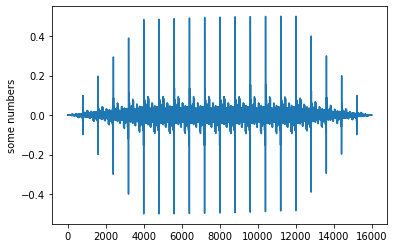

In [165]:
import matplotlib.pyplot as plt
plt.plot(DATA['data'][1])
plt.ylabel('some numbers')
plt.show()

In [168]:
import IPython
IPython.display.display(IPython.display.Audio(DATA['data'][0], rate = 16000))

In [28]:
synthesis_names = ['amp_mod', 'freq_mod','additive', 'sustractive']
env = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step=0.01, description= key,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

env_synths = dict(zip(synthesis_names,[env for x in range(len(synthesis_names))]))

envdur = [widgets.FloatSlider(value= 0.5, min=envdict[key][0], max=envdict[key][1], step= 0.01, description= key+'dur',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout= False,
    readout_format='d',
)for key in envdict.keys()]

env_dur_synths = dict(zip(synthesis_names,[envdur for x in range(len(synthesis_names))]))

gen = [widgets.BoundedIntText(value=7, min=0, max=10,step=1,description='AMOUNT:',disabled=False),
       widgets.Text(value='Synth', placeholder='Type something', description='group_id:', disabled=False)
]
settings_synth = dict(zip(synthesis_names,[gen for x in range(len(synthesis_names))]))


7

In [29]:
settings_synth['amp_mod'][0].value

7

In [ ]:
def normalize_sum(values):
  env_val = np.array([x.value for x in values])
  env_val = env_val/ env_val.min()
  env_val = env_val/env_val.sum()
  return env_val

z = normalize_sum(env)
z

array([0.19852941, 0.06617647, 0.27205882, 0.46323529])

In [153]:
 def additive(freq = 100, dur= 1, harms = 3):
    
    i = 1
    t = np.linspace(0, dur, math.ceil(16000 * dur))
    ### initialize a new output
    sig = np.zeros(t.size)
    for i in range(harms):
    
      if i == 0:
         x = np.multiply(sinusoid(freq * i, dur),0.5)
         sig = sig + x
         i+=1
      else:
        x = np.multiply(sinusoid(freq * i, dur), np.random.rand(1)[0])
        sig = sig + x
        i+=1
      
    ### making sure the maximum amplitude does not exeed 1
    if np.max(sig)>abs(np.min(sig)):
        sig = sig / np.max(sig)
    else:
        sig = sig / -np.min(sig)
    return sig 

(16000,)


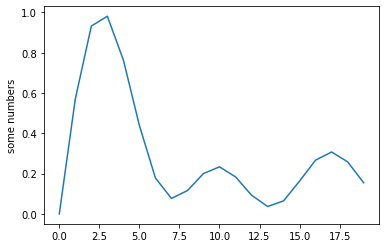

In [158]:
s = additive(harms= 24)
print(s.shape)
import matplotlib.pyplot as plt
plt.plot(s[:20])
plt.ylabel('some numbers')
plt.show()

In [124]:
import IPython
IPython.display.display(IPython.display.Audio(s, rate = 16000))